In [1]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# This is for the progress bar.
from tqdm.auto import tqdm
from tqdm import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil
shutil.rmtree('/content/drive/MyDrive/Food/evaluation')
shutil.rmtree('/content/drive/MyDrive/Food/training')
shutil.rmtree('/content/drive/MyDrive/Food/validation')

In [4]:
import zipfile
extract_ref = zipfile.ZipFile("/content/drive/MyDrive/Food/archive.zip", 'r')
extract_ref.extractall("/content/drive/MyDrive/Food")

#!unzip /content/drive/MyDrive/Food/archive.zip

Adjusting the size of each image to 224 x 224 and transforming the output to tensor.

In [5]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food classification.
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    # Randomly apply horizontal flip with a probability of 0.5
    transforms.RandomHorizontalFlip(),
    # Randomly rotate the image by a certain degree (e.g., between -10 and 10 degrees)
    transforms.RandomRotation(degrees=10),
    # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Randomly apply affine transformations (e.g., scale, shear)
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation of ImageNet dataset
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
# # It is important to do data augmentation in training.
# # However, not every augmentation is useful.
# # Please think about what kind of augmentation is helpful for facial expression recognition.
# train_transform = transforms.Compose([
#     # Resize the image into a fixed shape (height = width = 224)
#     transforms.Resize((224, 224)),
#     # You may add some transforms here.
#     # ToTensor() should be the last one of the transforms.
#     transforms.ToTensor(),
# ])

# # We don't need augmentations in testing and validation.
# # All we need here is to resize the PIL image and transform it into Tensor.
# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

In [6]:
# Construct datasets.
train_dataset = datasets.ImageFolder("/content/drive/MyDrive/Food/training", transform=test_transform)
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/Food/evaluation", transform=test_transform)
val_dataset = datasets.ImageFolder("/content/drive/MyDrive/Food/validation", transform=val_transform)


print(f'Original train set has {len(train_dataset)} samples')
print(f'Validation set has {len(val_dataset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 9866 samples
Validation set has 3430 samples
Test set has 3347 samples


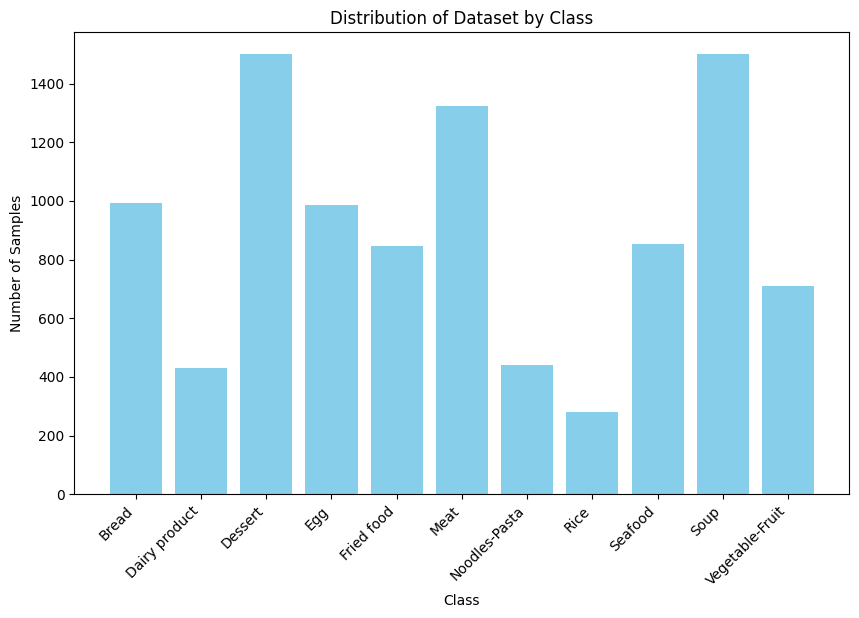

In [9]:
class_counts = {}
class_names = train_dataset.classes
for class_name in class_names:
    class_counts[class_name] = 0

for _, label in train_dataset:
    class_name = class_names[label]
    class_counts[class_name] += 1

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Dataset by Class')
plt.xticks(rotation=45, ha='right')
plt.show()


In [7]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

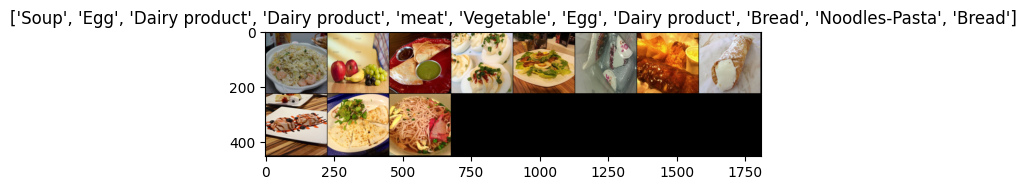

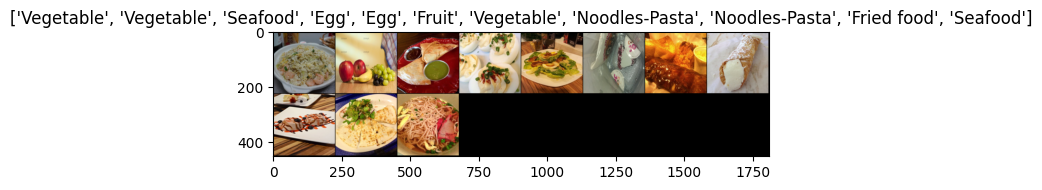

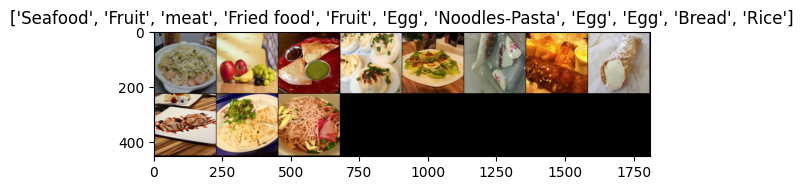

In [8]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_dataset, batch_size=11, shuffle=True, num_workers=0)
inputs, classes_train = next(iter(train_loader_for_vis))

# Get a batch of test data
test_loader_for_vis = DataLoader(test_dataset, batch_size=11, shuffle=True, num_workers=0)
inputs, classes_test = next(iter(test_loader_for_vis))

# Get a batch of Validation data
val_loader_for_vis = DataLoader(val_dataset, batch_size=11, shuffle=True, num_workers=0)
inputs, classes_val = next(iter(val_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Bread', 'Dairy product', 'Egg', 'Fried food', 'meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable', 'Fruit']

imshow(out, title=[class_names[x] for x in classes_train])
imshow(out, title=[class_names[x] for x in classes_test])
imshow(out, title=[class_names[x] for x in classes_val])

In [9]:
# Determine if CUDA is available and use it if possible
device = "cuda" if torch.cuda.is_available() else "cpu"



Loss and Optimizer

In [10]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
#optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.0003) #(lr=0.)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001) #(lr=0.)

ResNet Model

Fine Tuning

In [11]:
#model = torchvision.models.resnet18()
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')


# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Add a new layer
num_classes = 11
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# tell me who requires gradients
print('layers require gradients:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

#optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #(lr=0.)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #(lr=0.)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


layers require gradients:
fc.weight
fc.bias


In [12]:
# The number of training epochs.
n_epochs = 50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

100%|██████████| 27/27 [00:36<00:00,  1.33s/it]


[Epoch: 001/050] Train: loss=2.27002, acc=0.17278 | Valid: loss=2.11047, acc=0.25880


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


[Epoch: 002/050] Train: loss=1.96965, acc=0.34471 | Valid: loss=1.85148, acc=0.40689


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 003/050] Train: loss=1.73908, acc=0.47230 | Valid: loss=1.65554, acc=0.50173


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


[Epoch: 004/050] Train: loss=1.56119, acc=0.55667 | Valid: loss=1.49717, acc=0.58696


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 005/050] Train: loss=1.42413, acc=0.60938 | Valid: loss=1.39169, acc=0.61872


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


[Epoch: 006/050] Train: loss=1.31765, acc=0.64774 | Valid: loss=1.30010, acc=0.64167


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


[Epoch: 007/050] Train: loss=1.23430, acc=0.67105 | Valid: loss=1.21869, acc=0.68116


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 008/050] Train: loss=1.16151, acc=0.69089 | Valid: loss=1.15666, acc=0.68869


100%|██████████| 27/27 [00:36<00:00,  1.35s/it]


[Epoch: 009/050] Train: loss=1.10316, acc=0.70002 | Valid: loss=1.10964, acc=0.69751


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 010/050] Train: loss=1.05642, acc=0.71731 | Valid: loss=1.05944, acc=0.70706


100%|██████████| 27/27 [00:36<00:00,  1.34s/it]


[Epoch: 011/050] Train: loss=1.01492, acc=0.72169 | Valid: loss=1.02301, acc=0.71140


100%|██████████| 27/27 [00:36<00:00,  1.33s/it]


[Epoch: 012/050] Train: loss=0.97315, acc=0.73373 | Valid: loss=0.98655, acc=0.72667


100%|██████████| 27/27 [00:34<00:00,  1.29s/it]


[Epoch: 013/050] Train: loss=0.94332, acc=0.73878 | Valid: loss=0.95924, acc=0.72942


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


[Epoch: 014/050] Train: loss=0.91801, acc=0.74700 | Valid: loss=0.93971, acc=0.73073


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


[Epoch: 015/050] Train: loss=0.89430, acc=0.75118 | Valid: loss=0.91504, acc=0.73520


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 016/050] Train: loss=0.86479, acc=0.75663 | Valid: loss=0.89899, acc=0.74164


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 017/050] Train: loss=0.84558, acc=0.76184 | Valid: loss=0.87936, acc=0.74620


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 018/050] Train: loss=0.82743, acc=0.76589 | Valid: loss=0.86907, acc=0.74330


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


[Epoch: 019/050] Train: loss=0.81430, acc=0.76460 | Valid: loss=0.84501, acc=0.74968


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


[Epoch: 020/050] Train: loss=0.79850, acc=0.77190 | Valid: loss=0.83341, acc=0.74932


100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


[Epoch: 021/050] Train: loss=0.78143, acc=0.77448 | Valid: loss=0.82226, acc=0.75618


100%|██████████| 27/27 [00:36<00:00,  1.37s/it]


[Epoch: 022/050] Train: loss=0.77114, acc=0.77394 | Valid: loss=0.81116, acc=0.75937


100%|██████████| 27/27 [00:36<00:00,  1.34s/it]


[Epoch: 023/050] Train: loss=0.76114, acc=0.77662 | Valid: loss=0.79857, acc=0.76191


100%|██████████| 27/27 [00:46<00:00,  1.72s/it]


[Epoch: 024/050] Train: loss=0.75419, acc=0.77674 | Valid: loss=0.78222, acc=0.76632


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


[Epoch: 025/050] Train: loss=0.73233, acc=0.78510 | Valid: loss=0.77721, acc=0.76762


100%|██████████| 27/27 [00:36<00:00,  1.34s/it]


[Epoch: 026/050] Train: loss=0.73196, acc=0.78163 | Valid: loss=0.77777, acc=0.76320


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 027/050] Train: loss=0.72190, acc=0.78730 | Valid: loss=0.76664, acc=0.76457


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 028/050] Train: loss=0.70944, acc=0.79091 | Valid: loss=0.75985, acc=0.76406


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


[Epoch: 029/050] Train: loss=0.69837, acc=0.79251 | Valid: loss=0.75521, acc=0.76408


100%|██████████| 27/27 [00:36<00:00,  1.34s/it]


[Epoch: 030/050] Train: loss=0.69873, acc=0.78972 | Valid: loss=0.75593, acc=0.76639


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 031/050] Train: loss=0.68404, acc=0.79800 | Valid: loss=0.74800, acc=0.76863


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]


[Epoch: 032/050] Train: loss=0.68190, acc=0.79539 | Valid: loss=0.73618, acc=0.77341


100%|██████████| 27/27 [00:36<00:00,  1.36s/it]


[Epoch: 033/050] Train: loss=0.67727, acc=0.79245 | Valid: loss=0.73401, acc=0.77246


100%|██████████| 27/27 [00:34<00:00,  1.28s/it]


[Epoch: 034/050] Train: loss=0.66725, acc=0.80070 | Valid: loss=0.73127, acc=0.77015


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 035/050] Train: loss=0.66498, acc=0.79924 | Valid: loss=0.73562, acc=0.77056


100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


[Epoch: 036/050] Train: loss=0.65271, acc=0.80250 | Valid: loss=0.72352, acc=0.77159


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


[Epoch: 037/050] Train: loss=0.65800, acc=0.80214 | Valid: loss=0.71525, acc=0.77688


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 038/050] Train: loss=0.64812, acc=0.80601 | Valid: loss=0.70808, acc=0.77515


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 039/050] Train: loss=0.64291, acc=0.80821 | Valid: loss=0.70459, acc=0.77774


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 040/050] Train: loss=0.63009, acc=0.81060 | Valid: loss=0.70471, acc=0.77601


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 041/050] Train: loss=0.63180, acc=0.80647 | Valid: loss=0.70854, acc=0.77478


100%|██████████| 27/27 [00:34<00:00,  1.29s/it]


[Epoch: 042/050] Train: loss=0.63033, acc=0.80545 | Valid: loss=0.69945, acc=0.77464


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 043/050] Train: loss=0.63138, acc=0.80619 | Valid: loss=0.69224, acc=0.77783


100%|██████████| 27/27 [00:34<00:00,  1.28s/it]


[Epoch: 044/050] Train: loss=0.62311, acc=0.81284 | Valid: loss=0.68833, acc=0.78158


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


[Epoch: 045/050] Train: loss=0.61669, acc=0.80974 | Valid: loss=0.69994, acc=0.77391


100%|██████████| 27/27 [00:34<00:00,  1.28s/it]


[Epoch: 046/050] Train: loss=0.61330, acc=0.80897 | Valid: loss=0.68553, acc=0.78108


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 047/050] Train: loss=0.61399, acc=0.81188 | Valid: loss=0.69105, acc=0.77998


100%|██████████| 27/27 [00:34<00:00,  1.28s/it]


[Epoch: 048/050] Train: loss=0.60278, acc=0.81675 | Valid: loss=0.68069, acc=0.78216


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


[Epoch: 049/050] Train: loss=0.60224, acc=0.81544 | Valid: loss=0.67875, acc=0.78209


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]

[Epoch: 050/050] Train: loss=0.60142, acc=0.81466 | Valid: loss=0.68179, acc=0.77833


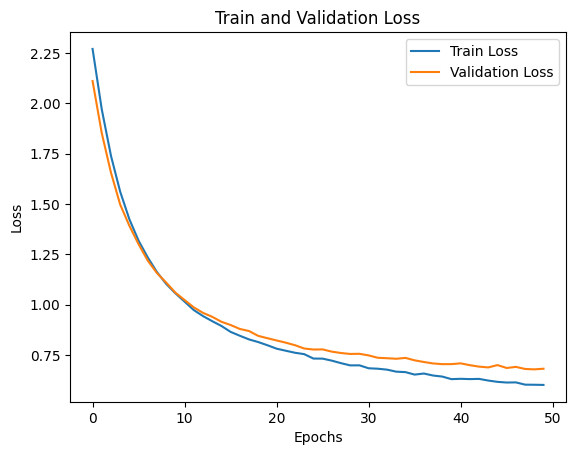

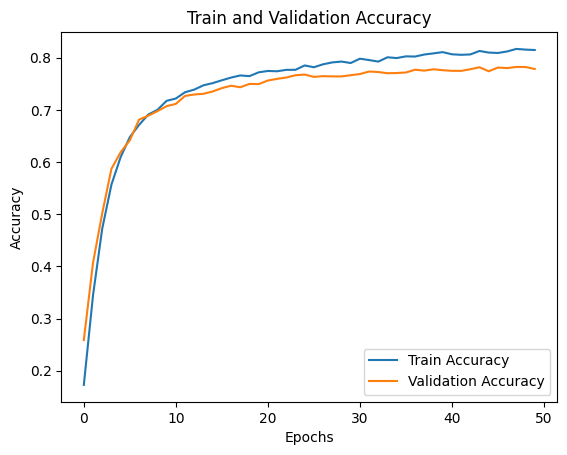

In [13]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

## Test

In [14]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

100%|██████████| 27/27 [00:30<00:00,  1.13s/it]

Test accuracy 0.8151803016662598


VGG16

In [15]:
class MyVGG16(nn.Module):
    def __init__(self):  # Corrected the method name
        super(MyVGG16, self).__init__()  # Corrected the method name

        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Extract only the convolutional layers from the pre-trained VGG16 model
        self.features = vgg16.features

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 11)  # Output layer with 11 classes
        )

    def forward(self, x):
        # Extract features using VGG16's convolutional layers
        x = self.features(x)

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x


In [16]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model, criterion, and optimizer
model = MyVGG16()
model = model.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]


In [17]:

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0003)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [18]:
# The number of training epochs.
n_epochs = 50

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 3.45 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 4.83 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 6.89 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variabl

[Epoch: 001/050] Train: loss=2.40079, acc=0.11534 | Valid: loss=2.38274, acc=0.15366


100%|██████████| 27/27 [00:47<00:00,  1.78s/it]


[Epoch: 002/050] Train: loss=2.38015, acc=0.14581 | Valid: loss=2.36559, acc=0.15786


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 003/050] Train: loss=2.36016, acc=0.15952 | Valid: loss=2.34960, acc=0.15592


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 004/050] Train: loss=2.34667, acc=0.17590 | Valid: loss=2.33440, acc=0.15779


100%|██████████| 27/27 [00:49<00:00,  1.82s/it]


[Epoch: 005/050] Train: loss=2.33265, acc=0.17386 | Valid: loss=2.31941, acc=0.16285


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 006/050] Train: loss=2.31373, acc=0.18884 | Valid: loss=2.30436, acc=0.16706


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 007/050] Train: loss=2.30009, acc=0.19435 | Valid: loss=2.28980, acc=0.17696


100%|██████████| 27/27 [00:47<00:00,  1.76s/it]


[Epoch: 008/050] Train: loss=2.28529, acc=0.19637 | Valid: loss=2.27424, acc=0.18587


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 009/050] Train: loss=2.26900, acc=0.20116 | Valid: loss=2.25871, acc=0.19535


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 010/050] Train: loss=2.25629, acc=0.20609 | Valid: loss=2.24300, acc=0.21191


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


[Epoch: 011/050] Train: loss=2.24104, acc=0.21528 | Valid: loss=2.22603, acc=0.22066


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 012/050] Train: loss=2.21902, acc=0.22328 | Valid: loss=2.20818, acc=0.23145


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 013/050] Train: loss=2.20442, acc=0.22841 | Valid: loss=2.19018, acc=0.24648


100%|██████████| 27/27 [00:51<00:00,  1.91s/it]


[Epoch: 014/050] Train: loss=2.18647, acc=0.23620 | Valid: loss=2.17032, acc=0.25800


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


[Epoch: 015/050] Train: loss=2.17242, acc=0.24034 | Valid: loss=2.14977, acc=0.26668


100%|██████████| 27/27 [00:49<00:00,  1.82s/it]


[Epoch: 016/050] Train: loss=2.14522, acc=0.25801 | Valid: loss=2.12790, acc=0.27369


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 017/050] Train: loss=2.13133, acc=0.25976 | Valid: loss=2.10439, acc=0.28694


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


[Epoch: 018/050] Train: loss=2.10273, acc=0.27143 | Valid: loss=2.08053, acc=0.29605


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 019/050] Train: loss=2.08382, acc=0.28892 | Valid: loss=2.05437, acc=0.30358


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 020/050] Train: loss=2.06304, acc=0.29169 | Valid: loss=2.02617, acc=0.31226


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 021/050] Train: loss=2.04206, acc=0.30028 | Valid: loss=1.99799, acc=0.32232


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 022/050] Train: loss=2.01376, acc=0.31344 | Valid: loss=1.96592, acc=0.33361


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


[Epoch: 023/050] Train: loss=1.98778, acc=0.32298 | Valid: loss=1.93422, acc=0.34646


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 024/050] Train: loss=1.95278, acc=0.33265 | Valid: loss=1.89712, acc=0.37071


100%|██████████| 27/27 [00:49<00:00,  1.85s/it]


[Epoch: 025/050] Train: loss=1.91688, acc=0.35088 | Valid: loss=1.85706, acc=0.39792


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


[Epoch: 026/050] Train: loss=1.88267, acc=0.36270 | Valid: loss=1.81374, acc=0.42744


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 027/050] Train: loss=1.84798, acc=0.38213 | Valid: loss=1.76747, acc=0.45514


100%|██████████| 27/27 [00:47<00:00,  1.75s/it]


[Epoch: 028/050] Train: loss=1.79954, acc=0.40733 | Valid: loss=1.71671, acc=0.47916


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 029/050] Train: loss=1.75637, acc=0.41921 | Valid: loss=1.66283, acc=0.50217


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 030/050] Train: loss=1.72022, acc=0.43171 | Valid: loss=1.60805, acc=0.51555


100%|██████████| 27/27 [00:47<00:00,  1.75s/it]


[Epoch: 031/050] Train: loss=1.67329, acc=0.44914 | Valid: loss=1.55092, acc=0.53197


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 032/050] Train: loss=1.61948, acc=0.46102 | Valid: loss=1.49369, acc=0.54753


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


[Epoch: 033/050] Train: loss=1.58125, acc=0.47085 | Valid: loss=1.44003, acc=0.56605


100%|██████████| 27/27 [00:47<00:00,  1.76s/it]


[Epoch: 034/050] Train: loss=1.53031, acc=0.48353 | Valid: loss=1.38751, acc=0.58428


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 035/050] Train: loss=1.47374, acc=0.51142 | Valid: loss=1.33506, acc=0.59368


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 036/050] Train: loss=1.44476, acc=0.51833 | Valid: loss=1.29650, acc=0.59832


100%|██████████| 27/27 [00:47<00:00,  1.75s/it]


[Epoch: 037/050] Train: loss=1.40488, acc=0.52821 | Valid: loss=1.25236, acc=0.61083


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 038/050] Train: loss=1.38081, acc=0.53257 | Valid: loss=1.21967, acc=0.62023


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


[Epoch: 039/050] Train: loss=1.32874, acc=0.54842 | Valid: loss=1.18553, acc=0.62552


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


[Epoch: 040/050] Train: loss=1.30897, acc=0.55379 | Valid: loss=1.15573, acc=0.63312


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


[Epoch: 041/050] Train: loss=1.27095, acc=0.56312 | Valid: loss=1.12777, acc=0.63992


100%|██████████| 27/27 [00:47<00:00,  1.78s/it]


[Epoch: 042/050] Train: loss=1.24043, acc=0.58329 | Valid: loss=1.10083, acc=0.65012


100%|██████████| 27/27 [00:48<00:00,  1.80s/it]


[Epoch: 043/050] Train: loss=1.21296, acc=0.58522 | Valid: loss=1.07996, acc=0.65367


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 044/050] Train: loss=1.19342, acc=0.59523 | Valid: loss=1.05541, acc=0.66018


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


[Epoch: 045/050] Train: loss=1.15792, acc=0.60126 | Valid: loss=1.03316, acc=0.66742


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 046/050] Train: loss=1.13923, acc=0.61122 | Valid: loss=1.01493, acc=0.67052


100%|██████████| 27/27 [00:48<00:00,  1.78s/it]


[Epoch: 047/050] Train: loss=1.11165, acc=0.62206 | Valid: loss=0.99857, acc=0.67581


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 048/050] Train: loss=1.10046, acc=0.62278 | Valid: loss=0.98555, acc=0.67892


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


[Epoch: 049/050] Train: loss=1.08532, acc=0.63227 | Valid: loss=0.97004, acc=0.68268


100%|██████████| 27/27 [00:48<00:00,  1.79s/it]


[Epoch: 050/050] Train: loss=1.05887, acc=0.63588 | Valid: loss=0.95021, acc=0.69290


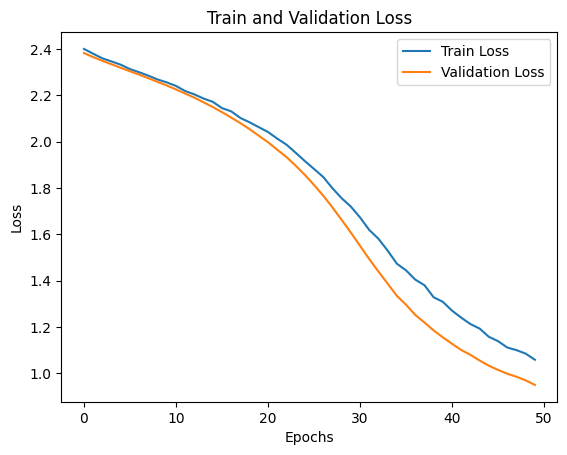

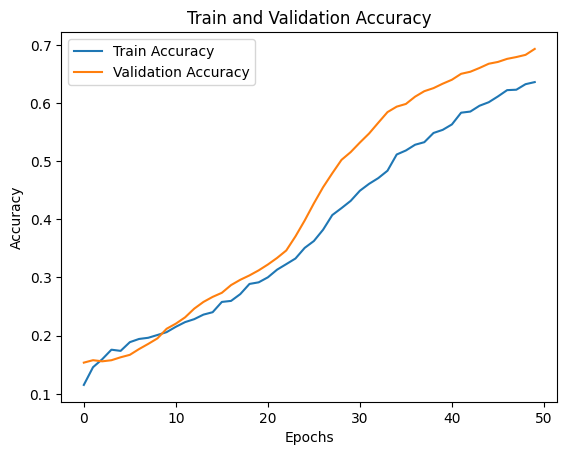

In [19]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

## Testing

In [20]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

100%|██████████| 27/27 [00:32<00:00,  1.22s/it]

Test accuracy 0.7222983837127686
